In [1]:
import pandas as pd
import numpy as np
import mne


# Loading data

This notebook is for creating a class that is capable to loading data in a format that can later be used by standard models already implemented by sckit-learn and PyTorch.

In [6]:
DATA_ROOT = '../data/ds004902-download'
PARTICIPANTS_TSV = f'{DATA_ROOT}/participants.tsv'

In [3]:
participant_df = pd.read_csv(PARTICIPANTS_TSV, sep='\t')

In [4]:
session_order = participant_df[['participant_id', 'SessionOrder']]

In [5]:
# create ses-1 column based on the first two characters of the session order
session_order['ses-1'] = session_order['SessionOrder'].str[:2]
session_order['ses-2'] = session_order['SessionOrder'].str[4:]

C:\Users\beama\AppData\Local\Temp\ipykernel_13324\488965073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
C:\Users\beama\AppData\Local\Temp\ipykernel_13324\488965073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


In [6]:
session_order = session_order.drop(columns=['SessionOrder'])

In [7]:
session_order

,participant_id,ses-1,ses-2
0,sub-01,NS,SD
1,sub-02,NS,SD
2,sub-03,NS,SD
3,sub-04,NS,SD
4,sub-05,NS,SD
...,...,...,...
66,sub-67,SD,NS
67,sub-68,SD,NS
68,sub-69,NS,SD
69,sub-70,NS,SD


Getting classes per session in regards to participants. Regarding the paper, there were two different type of group: the ones who had normal sleep first and those who were sleep deprived first. With this information we can identify which session has reading from which type of experiment.

In [8]:
session_order['ses-1'].value_counts()

ses-1
NS    41
SD    30
Name: count, dtype: int64

In [9]:
session_order['ses-2'].value_counts()

ses-2
SD    41
NS    30
Name: count, dtype: int64

In [10]:
session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

In [11]:
session_order

,participant_id,ses-1,ses-2
0,sub-01,0,1
1,sub-02,0,1
2,sub-03,0,1
3,sub-04,0,1
4,sub-05,0,1
...,...,...,...
66,sub-67,1,0
67,sub-68,1,0
68,sub-69,0,1
69,sub-70,0,1


In [12]:

class LoadData:
    def __init__(self, root, experiment_type: int):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """

        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        self.labels = self.get_classes()
    

    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order
    

In [13]:
session_order

,participant_id,ses-1,ses-2
0,sub-01,0,1
1,sub-02,0,1
2,sub-03,0,1
3,sub-04,0,1
4,sub-05,0,1
...,...,...,...
66,sub-67,1,0
67,sub-68,1,0
68,sub-69,0,1
69,sub-70,0,1


In [14]:
def load_raw_eeg(example, root, participant_id, session, task, class_label):
    try:
        aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()

        if class_label:
            example[f"{task}_sd"] = aux_eeg
        else:
            example[f"{task}_ns"] = aux_eeg 
    
    except FileNotFoundError:
        print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")

    except RuntimeError as e:
        print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")

    return example

data_examples = []
for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
    example = dict()
    example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
    example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
    example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
    example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)

    data_examples.append(example)

Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesclosed_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Error loading participant sub-01 with session ses-2 and task eyesopen: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesclosed_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Readi

C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-46, the file sub-46_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
For participant sub-47, the file sub-47_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-2\eeg\sub-47_ses-2_task-eyesopen_eeg.fdt
For participant sub-47, the file sub-47_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
For participant sub-48, the file sub-48_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
For part

C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-51, the file sub-51_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-52\ses-1\eeg\sub-52_ses-1_task-eyesopen_eeg.fdt
For participant sub-52, the file sub-52_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-52, the file sub-52_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
For participant sub-53, the file sub-53_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
For participant sub-53, the file sub-53_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
For participant sub-54, the file sub-54_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
For part

C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-57, the file sub-57_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-57, the file sub-57_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
For participant sub-58, the file sub-58_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-2\eeg\sub-58_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-58, the file sub-58_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt
For participant sub-59, the file sub-59_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-59, the file sub-59_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-60, the file sub-60_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt
For participant sub-60, the file sub-60_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
For participant sub-61, the file sub-61_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
For participant sub-61, the file sub-61_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
For part

C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-62, the file sub-62_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt
For participant sub-63, the file sub-63_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-63\ses-2\eeg\sub-63_ses-2_task-eyesopen_eeg.fdt
For participant sub-63, the file sub-63_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-64\ses-1\eeg\sub-64_ses-1_task-eyesopen_eeg.fdt
For participant sub-64, the file sub-64_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-64\ses-2\eeg\sub-64_ses-2_task-eyesopen_eeg.fdt
For part

C:\Users\beama\AppData\Local\Temp\ipykernel_11748\1019483413.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


For participant sub-65, the file sub-65_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-66\ses-1\eeg\sub-66_ses-1_task-eyesopen_eeg.fdt
For participant sub-66, the file sub-66_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-66\ses-2\eeg\sub-66_ses-2_task-eyesopen_eeg.fdt
For participant sub-66, the file sub-66_ses-2_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-67\ses-1\eeg\sub-67_ses-1_task-eyesopen_eeg.fdt
For participant sub-67, the file sub-67_ses-1_task-eyesclosed_eeg.set was not found
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-67\ses-2\eeg\sub-67_ses-2_task-eyesopen_eeg.fdt
For part

In [15]:
sum_type = {"open_sd": 0, "open_ns": 0, "closed_sd": 0, "closed_ns": 0}
for example in data_examples:
    if "eyesopen_sd" in example:
        sum_type["open_sd"] += 1
    if "eyesopen_ns" in example:
        sum_type["open_ns"] += 1
    if "eyesclosed_sd" in example:
        sum_type["closed_sd"] += 1
    if "eyesclosed_ns" in example:
        sum_type["closed_ns"] += 1

sum_type

{'open_sd': 70, 'open_ns': 68, 'closed_sd': 36, 'closed_ns': 38}

In [16]:
import matplotlib.pyplot as plt

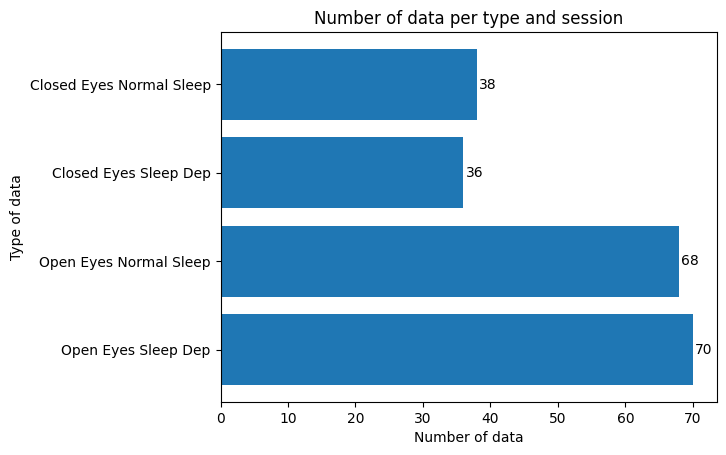

In [17]:
# plot the number of type of data
plt.barh(sum_type.keys(), sum_type.values(),)
plt.title("Number of data per type and session")
plt.xlabel("Number of data")
plt.ylabel("Type of data")

# list of yticks
yticks = ["Open Eyes Sleep Dep", "Open Eyes Normal Sleep", "Closed Eyes Sleep Dep", "Closed Eyes Normal Sleep"]
plt.yticks(range(4), yticks)

for i, v in enumerate((sum_type.values())):
    plt.text(v+0.30, i, str(round(v, 2)), color='black', va="center")

plt.show()

Some datas seemed either corrupeted or had bad compatibility with EEG. When loading a few of the examples on Mathlab EEGLAB, there was a warning that was displayed, however data was portraited. There could be some type of data corruption but that mathlab is prepared to deal with, while MNE is not.

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [19]:
class LoadData:
    def __init__(self, root, experiment_type: int, test_size: float = 0.2, random_state: int = 42, k_folds: int = 5):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """
        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        # get class labels
        self.raw_labels = self.get_classes()
        self.labels = []

        # create data examples
        self.raw_data = []
        self.data = []
        self._create_eeg_objects()

        # holdout information
        self.test_size = test_size
        self.random_state = random_state

        # cross-validation information
        self.k_folds = k_folds
        self.split_participants = []

        # train and test data
        self.test = None
        self.train = None

        # split data
        self._cross_validation()
    

    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order
    
    def _create_eeg_objects(self): 
        def load_raw_eeg(example, root, participant_id, session, task, class_label):
            try:
                aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
                if class_label:
                    example[f"{task}_sd"] = (aux_eeg, class_label)
                else:
                    example[f"{task}_ns"] = (aux_eeg, class_label)
            except FileNotFoundError:
                print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")
                aux_eeg = None
            except RuntimeError as e:
                print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")
                aux_eeg = None

            return example


        for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
            example = dict()
            if self.experiment_type == 1:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
            elif self.experiment_type == 2:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
            else:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)

            if len(example.keys()):
                print(example.keys())
                example['participant_id'] = participant_id

            self.raw_data.append(example) if example.keys() else None
        
        self.raw_data = np.array(self.raw_data)  


    def _holdout(self, participant_id):
        X_train, X_test, y_train, y_test = train_test_split(self.raw_data, participant_id, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def _cross_validation(self):
        participant_id = np.array([x['participant_id'] for x in self.raw_data])
        X_train, _, y_train, y_test_id = self._holdout(participant_id)

        skf = KFold(n_splits=self.k_folds)
        self.split_participants = list(skf.split(y_train))

        X_test = np.array([self.raw_data[i][col][0] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id'])
        y_test = np.array([self.raw_data[i][col][1] for i in y_test_id for col in self.raw_data[i].keys() if col != 'participant_id'])

        self.test = (X_test, y_test)

    def get_split_data(self, split):
        split_ids = self.split_participants[split]
        train_ids, test_ids = split_ids

        pass

        return self.split_participants

    def __len__(self):
        return len(self.data)
    


In [20]:
data = LoadData(DATA_ROOT, 1)

Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesclosed_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_11748\389866602.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
C:\Users\beama\AppData\Local\Temp\ipykernel_11748\389866602.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesclosed_eeg.fdt
dict_keys(['eyesclosed_ns', 'eyesclosed_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesclosed_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesclosed_eeg.fdt
dict_keys(['eyesclosed_ns', 'eyesclosed_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-03\ses-1\eeg\sub-03_ses-1_task-eyesclosed_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-03\ses-2\eeg\sub-03_ses-2_task-eyesclosed_eeg.fdt
Error loading participant sub-03 with session ses-2 and task eyesclosed: Incor

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
data.raw_data[0]

{'eyesclosed_ns': (array([[ 1.00400002e-04,  9.93000031e-05,  1.01599998e-04, ...,
           1.48000002e-05,  1.80000000e-05,  1.90000000e-05],
         [ 9.99000015e-05,  9.76999969e-05,  9.98000031e-05, ...,
           2.16000004e-05,  2.22000008e-05,  2.40000000e-05],
         [ 8.29000015e-05,  8.20999985e-05,  8.55999985e-05, ...,
           2.40000000e-05,  2.57000008e-05,  2.68999996e-05],
         ...,
         [ 8.51999969e-05,  8.45999985e-05,  8.69000015e-05, ...,
           1.76000004e-05,  1.90000000e-05,  2.05000000e-05],
         [ 7.30000000e-05,  7.19000015e-05,  7.43000031e-05, ...,
          -2.07999992e-05, -1.91000004e-05, -1.63999996e-05],
         [ 8.01999969e-05,  7.80000000e-05,  8.35999985e-05, ...,
          -1.20000000e-05, -1.20000000e-05, -1.05000000e-05]]),
  0),
 'eyesclosed_sd': (array([[-1.19699997e-04, -1.17800003e-04, -1.18199997e-04, ...,
          -7.65000000e-05, -7.35000000e-05, -7.28000031e-05],
         [-9.60000038e-06, -7.09999990e-06, -9.1

In [ ]:
len(data.raw_data)

38

In [ ]:
# Data example
data.raw_data[0]

{'eyesclosed_ns': (array([[ 1.00400002e-04,  9.93000031e-05,  1.01599998e-04, ...,
           1.48000002e-05,  1.80000000e-05,  1.90000000e-05],
         [ 9.99000015e-05,  9.76999969e-05,  9.98000031e-05, ...,
           2.16000004e-05,  2.22000008e-05,  2.40000000e-05],
         [ 8.29000015e-05,  8.20999985e-05,  8.55999985e-05, ...,
           2.40000000e-05,  2.57000008e-05,  2.68999996e-05],
         ...,
         [ 8.51999969e-05,  8.45999985e-05,  8.69000015e-05, ...,
           1.76000004e-05,  1.90000000e-05,  2.05000000e-05],
         [ 7.30000000e-05,  7.19000015e-05,  7.43000031e-05, ...,
          -2.07999992e-05, -1.91000004e-05, -1.63999996e-05],
         [ 8.01999969e-05,  7.80000000e-05,  8.35999985e-05, ...,
          -1.20000000e-05, -1.20000000e-05, -1.05000000e-05]]),
  0),
 'eyesclosed_sd': (array([[-1.19699997e-04, -1.17800003e-04, -1.18199997e-04, ...,
          -7.65000000e-05, -7.35000000e-05, -7.28000031e-05],
         [-9.60000038e-06, -7.09999990e-06, -9.1

In [ ]:
# list of participant folder ids and their position in the raw data
participant_id = np.array([x['participant_id'] for x in data.raw_data])
participant_index = np.arange(len(participant_id))

In [ ]:
# Participants id that are in the dataset
participant_id

array(['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06',
       'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
       'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18',
       'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24',
       'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30',
       'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36',
       'sub-37', 'sub-38'], dtype='<U6')

In [ ]:
# Dividing data into "train" and "test" sets. Using the ids and indexs in order to create sets
# This means that y_train and y_test will have the data index position, that can later be used to get data
X_train, X_test, y_train, y_test = train_test_split(participant_id, participant_index, test_size=data.test_size, random_state=data.random_state)

In [ ]:
X_train

array(['sub-25', 'sub-16', 'sub-18', 'sub-09', 'sub-17', 'sub-13',
       'sub-20', 'sub-10', 'sub-33', 'sub-01', 'sub-26', 'sub-06',
       'sub-12', 'sub-02', 'sub-38', 'sub-22', 'sub-03', 'sub-30',
       'sub-36', 'sub-04', 'sub-35', 'sub-24', 'sub-32', 'sub-11',
       'sub-23', 'sub-19', 'sub-21', 'sub-08', 'sub-15', 'sub-29'],
      dtype='<U6')

In [ ]:
y_train

array([24, 15, 17,  8, 16, 12, 19,  9, 32,  0, 25,  5, 11,  1, 37, 21,  2,
       29, 35,  3, 34, 23, 31, 10, 22, 18, 20,  7, 14, 28])

In [ ]:
# initilize kfold with 5 splits. 
# KFold is being used instead of StratifiedKFold because we are using index and there is no class label at this moment
# This approach is to guarantee that the same participant is not in the train and test set, nor that the same participant is in different splits (data contamination)
skf = KFold(n_splits=data.k_folds)

In [ ]:
data.k_folds

5

In [ ]:
len(y_train)

30

In [ ]:
len(X_train)

30

In [ ]:
# creatiin list of splits in the format [(train_index, test_index), ...]
splits = list(skf.split(y_train))

In [ ]:
splits

[(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
         23, 24, 25, 26, 27, 28, 29]),
  array([0, 1, 2, 3, 4, 5])),
 (array([ 0,  1,  2,  3,  4,  5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
         23, 24, 25, 26, 27, 28, 29]),
  array([ 6,  7,  8,  9, 10, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 18, 19, 20, 21, 22,
         23, 24, 25, 26, 27, 28, 29]),
  array([12, 13, 14, 15, 16, 17])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 24, 25, 26, 27, 28, 29]),
  array([18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23]),
  array([24, 25, 26, 27, 28, 29]))]

In [ ]:
train_ids, test_ids = splits[0]

In [ ]:
train_ids

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29])

In [ ]:
# dividing the data into train and val sets, using the ids and indexs in order to create sets
X_train =[data.raw_data[i][col][0] for i in train_ids for col in data.raw_data[i].keys() if col != 'participant_id']
y_train = np.array([data.raw_data[i][col][1] for i in train_ids for col in data.raw_data[i].keys() if col != 'participant_id'])
        
X_val = [data.raw_data[i][col][0] for i in test_ids for col in data.raw_data[i].keys() if col != 'participant_id']
y_val = np.array([data.raw_data[i][col][1] for i in test_ids for col in data.raw_data[i].keys() if col != 'participant_id'])

In [ ]:
len(X_train)

47

In [ ]:
class LoadData:
    def __init__(self, root, experiment_type: int, test_size: float = 0.2, random_state: int = 42, k_folds: int = 5):
        """
        ROOT: path to the root directory of the dataset

        Experiment type:
            1: Eyes Closed
            2: Eyes open
            3: Both
        """
        self.DATA_ROOT = root
        self.PARTICIPANTS_TSV = f'{self.DATA_ROOT}/participants.tsv'
        self.experiment_type = experiment_type

        # get class labels
        self.raw_labels = self.get_classes()
        self.labels = []

        # create data examples
        self.raw_data = []
        self.data = []
        self._create_eeg_objects()

        # holdout information
        self.test_size = test_size
        self.random_state = random_state

        # cross-validation information
        self.k_folds = k_folds
        self.split_participants = []

        # train and test data
        self.test = None
        self.train = None

        # split data
        self._cross_validation()
    

    def get_classes(self):
        participant_df = pd.read_csv(self.PARTICIPANTS_TSV, sep='\t')
        session_order = participant_df[['participant_id', 'SessionOrder']]

        # create ses-1 column based on the first two characters of the session order
        session_order['ses-1'] = session_order['SessionOrder'].str[:2]
        session_order['ses-2'] = session_order['SessionOrder'].str[4:]

        session_order = session_order.drop(columns=['SessionOrder'])

        session_order['ses-1'] = session_order['ses-1'].apply(lambda x: 1 if x == 'SD' else 0)
        session_order['ses-2'] = session_order['ses-2'].apply(lambda x: 1 if x == 'SD' else 0)

        return session_order
    
    def _create_eeg_objects(self): 
        def load_raw_eeg(example, root, participant_id, session, task, class_label):
            try:
                aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
                if class_label:
                    example[f"{task}_sd"] = (aux_eeg, class_label)
                else:
                    example[f"{task}_ns"] = (aux_eeg, class_label)
            except FileNotFoundError:
                print(f"For participant {participant_id}, the file {participant_id}_{session}_task-{task}_eeg.set was not found")
                aux_eeg = None
            except RuntimeError as e:
                print(f"Error loading participant {participant_id} with session {session} and task {task}: {e}")
                aux_eeg = None

            return example


        for participant_id, ses_1, ses_2 in zip(session_order['participant_id'], session_order['ses-1'], session_order['ses-2']):
            example = dict()
            if self.experiment_type == 1:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
            elif self.experiment_type == 2:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)
            else:
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesclosed', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesclosed', ses_2)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-1', 'eyesopen', ses_1)
                example = load_raw_eeg(example, DATA_ROOT, participant_id, 'ses-2', 'eyesopen', ses_2)

            if len(example.keys()):
                print(example.keys())
                example['participant_id'] = participant_id

            self.raw_data.append(example) if example.keys() else None
        
        self.raw_data = np.array(self.raw_data)  


    def _holdout(self, participant_id, participant_index):
        X_train, X_test, y_train, y_test = train_test_split(participant_id, participant_index, test_size=self.test_size, random_state=self.random_state)
        return X_train, X_test, y_train, y_test

    def _cross_validation(self):
        participant_id = np.array([x['participant_id'] for x in data.raw_data])
        participant_index = np.arange(len(participant_id))

        X_train, _, y_train, y_test_id = self._holdout(participant_id, participant_index)
        
        # save test data
        X_test = np.array([self.raw_data[i][col][0] for i in test_ids for col in data.raw_data[i].keys() if col != 'participant_id'])
        y_test = np.array([self.raw_data[i][col][1] for i in y_test_id for col in data.raw_data[i].keys() if col != 'participant_id'])
        self.test = (X_test, y_test)

        # create splits
        skf = KFold(n_splits=self.k_folds)
        self.split_participants = list(skf.split(y_train))


    def get_split_data(self, split):
        split_ids = self.split_participants[split]
        train_ids, val_ids = split_ids

        X_train =[self.raw_data[i][col][0] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_train = np.array([self.raw_data[i][col][1] for i in train_ids for col in self.raw_data[i].keys() if col != 'participant_id'])
                
        X_val = [self.raw_data[i][col][0] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id']
        y_val = np.array([self.raw_data[i][col][1] for i in val_ids for col in self.raw_data[i].keys() if col != 'participant_id'])

        return X_train, X_val, y_train, y_val

    def __len__(self):
        return len(self.raw_data)

In [ ]:
del data

In [185]:
data = LoadData(DATA_ROOT, 2)

Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-1\eeg\sub-01_ses-1_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-1'] = session_order['SessionOrder'].str[:2]
C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_order['ses-2'] = session_order['SessionOrder'].str[4:]


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-01\ses-2\eeg\sub-01_ses-2_task-eyesopen_eeg.fdt
Error loading participant sub-01 with session ses-2 and task eyesopen: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers
dict_keys(['eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-1\eeg\sub-02_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-02\ses-2\eeg\sub-02_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-03\ses-1\eeg\sub-03_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-d

C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-1\eeg\sub-47_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-47\ses-2\eeg\sub-47_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-1\eeg\sub-48_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-48\ses-2\eeg\sub-48_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-49\ses-1\eeg\sub-49_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-depri

C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-52\ses-2\eeg\sub-52_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-1\eeg\sub-53_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-53\ses-2\eeg\sub-53_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-1\eeg\sub-54_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-54\ses-2\eeg\sub-54_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-55\ses-1\eeg\sub-55_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-depri

C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()
C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-57\ses-2\eeg\sub-57_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-1\eeg\sub-58_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-58\ses-2\eeg\sub-58_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-1\eeg\sub-59_ses-1_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-59\ses-2\eeg\sub-59_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-1\eeg\sub-60_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-60\ses-2\eeg\sub-60_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-1\eeg\sub-61_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-61\ses-2\eeg\sub-61_ses-2_task-eyesopen_eeg.fdt
dict_keys(['eyesopen_sd', 'eyesopen_ns'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-62\ses-1\eeg\sub-62_ses-1_task-eyesopen_eeg.fdt
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-62\ses-2\eeg\sub-62_ses-2_task-eyesopen_eeg.fdt


C:\Users\beama\AppData\Local\Temp\ipykernel_32352\1916139822.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  aux_eeg = mne.io.read_raw_eeglab(f"{root}/{participant_id}/{session}/eeg/{participant_id}_{session}_task-{task}_eeg.set").get_data()


dict_keys(['eyesopen_ns', 'eyesopen_sd'])
Reading c:\Users\beama\Documents\2024-2-P1-sleep-deprivation-classification\notebooks\..\data\ds004902-download\sub-63\ses-1\eeg\sub-63_ses-1_task-eyesopen_eeg.fdt


MemoryError: Unable to allocate 69.8 MiB for an array with shape (61, 150000) and data type float64